In [7]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
%matplotlib inline

In [8]:
warnings.simplefilter('ignore')
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(47)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms = None, meta_features = None):
        """
        Class initialization
        Args:
            df (pd.DataFrame): DataFrame with data description
            imfolder (str): folder with images
            train (bool): flag of whether a training dataset is being initialized or testing one
            transforms: image transformation method to be applied
            meta_features (list): list of features with meta information, such as sex and age
            
        """
        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.train = train
        self.meta_features = meta_features
        
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
        x = cv2.imread(im_path)
        meta = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)

        if self.transforms:
            x = self.transforms(x)
            
        if self.train:
            y = self.df.iloc[index]['target']
            return (x, meta), y
        else:
            return (x, meta)
    
    def __len__(self):
        return len(self.df)

In [11]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [13]:
train_df = pd.read_csv('/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/train/train_subset.csv')
test_df = pd.read_csv('/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/test/test_subset.csv')

In [15]:
concat = pd.concat([train_df['anatom_site_general_challenge'], test_df['anatom_site_general_challenge']], ignore_index=True)
dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
train_df = pd.concat([train_df, dummies.iloc[:train_df.shape[0]]], axis=1)
test_df = pd.concat([test_df, dummies.iloc[train_df.shape[0]:].reset_index(drop=True)], axis=1)

# Sex features
train_df['sex'] = train_df['sex'].map({'male': 1, 'female': 0})
test_df['sex'] = test_df['sex'].map({'male': 1, 'female': 0})
train_df['sex'] = train_df['sex'].fillna(-1)
test_df['sex'] = test_df['sex'].fillna(-1)

# Age features
train_df['age_approx'] /= train_df['age_approx'].max()
test_df['age_approx'] /= test_df['age_approx'].max()
train_df['age_approx'] = train_df['age_approx'].fillna(0)
test_df['age_approx'] = test_df['age_approx'].fillna(0)

train_df['patient_id'] = train_df['patient_id'].fillna(0)

In [17]:
meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]
meta_features.remove('anatom_site_general_challenge')

In [18]:
train = MelanomaDataset(df=train_df.reset_index(drop=True), 
                        imfolder='/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/train/images', 
                        train=True, 
                        transforms=train_transform,
                        meta_features=meta_features)





In [20]:
train.transforms

Compose(
    RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=BILINEAR)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [21]:
train.meta_features

['sex', 'age_approx', 'site_upper extremity', 'site_nan']

In [22]:
train.imfolder

'/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/train/images'

In [23]:
train.df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,site_upper extremity,site_nan
0,ISIC_0015719,IP_3075186,0,1.0,upper extremity,unknown,benign,0,1,0


In [24]:
test = MelanomaDataset(df=test_df,
                       imfolder='/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/test/images', 
                       train=False,
                       transforms=train_transform,  # For TTA
                       meta_features=meta_features)

In [25]:
test.df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,site_upper extremity,site_nan
0,ISIC_0052060,IP_3579794,1,1.0,NaN,0,1


In [33]:
train_loader = DataLoader(dataset=train, batch_size=64, shuffle=True, num_workers=2)

In [29]:
from torchvision import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


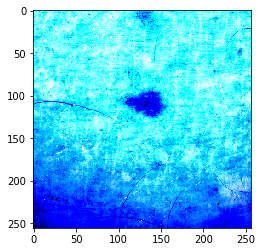

In [37]:
for i, sampled_batch in enumerate(train_loader):
    (x, meta), y = sampled_batch
    grid = utils.make_grid(x)
    plt.imshow(grid.numpy().transpose((2, 1, 0)))